In [292]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset


Dataset Class from CSV

In [293]:
#torch data set
class dataSetAll(Dataset):
    def __init__(self, yearLow, yearHigh):
        #import data from CDC
        self.df = pd.read_csv("data\FluViewPhase2Data\WHO_NREVSS_Combined_prior_to_2015_16.csv")
        self.df = self.df[(yearLow <= self.df["YEAR"]) & (self.df["YEAR"] < yearHigh)]
        #turn data into features and output
        #features: 5 previous + one from last year for predicted
        #output: prediction for next time

        #create test data
        numFeat = 5 #------------------------
        numOut = 1
        self.X = np.empty([numFeat,len(self.df)-numFeat-numOut],dtype=np.float32)
        self.Y = np.empty([numOut,len(self.df)-numFeat-numOut],dtype=np.float32)
        for i in range(self.Y.shape[1]):
            self.X[:,i] = np.asarray(self.df.iloc[i:i+numFeat]["TOTAL"])
            self.Y[:,i] = np.asarray(self.df.iloc[i+numFeat:i+numFeat+numOut]["TOTAL"])

        self.X = torch.from_numpy(self.X)
        self.Y = torch.from_numpy(self.Y)

    def __len__(self):
        return self.Y.shape[1]
    
    def __getitem__(self,idx):
        return self.X[:,idx].T, self.Y[:,idx]

Initialize test and train dataloaders

In [294]:
#create data loaders
train_data = dataSetAll(1900,2013)
test_data = dataSetAll(2013,2100)
train_dataloader = DataLoader(train_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

Create Neural Network Autoregression class

In [295]:
# create neural netowrk
class NeuralNetwork(nn.Module):
    def __init__(self):
        hidden = 400
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(5, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

Create train and tet loops

In [296]:
#train/test loop
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        # print(pred)
        # print(y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % size == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            # print(X)
            pred = model(X)
            # print(pred)
            test_loss += loss_fn(pred, y).item()
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error:\nAvg loss: {test_loss:>8f} \n")

Train the network

In [297]:
learning_rate = .000000001
batch_size = 64
epochs = 2000
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# print(list(model.parameters()))
for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    # test_loop(test_dataloader, model, loss_fn)

print("Done!")
# print(list(model.parameters()))

loss: 5693914.000000  [    0/  787]
loss: 11808908.000000  [    0/  787]
loss: 7784472.000000  [    0/  787]
loss: 2224874.000000  [    0/  787]
loss: 1541240.125000  [    0/  787]
loss: 1394129.750000  [    0/  787]
loss: 1296429.750000  [    0/  787]
loss: 1209432.125000  [    0/  787]
loss: 1132480.500000  [    0/  787]
loss: 1063068.750000  [    0/  787]
loss: 1001690.125000  [    0/  787]
loss: 947405.562500  [    0/  787]
loss: 899229.187500  [    0/  787]
loss: 857377.250000  [    0/  787]
loss: 821028.500000  [    0/  787]
loss: 789652.375000  [    0/  787]
loss: 762737.875000  [    0/  787]
loss: 739234.625000  [    0/  787]
loss: 718686.375000  [    0/  787]
loss: 701036.125000  [    0/  787]
loss: 685257.875000  [    0/  787]
loss: 670462.812500  [    0/  787]
loss: 657135.875000  [    0/  787]
loss: 644738.250000  [    0/  787]
loss: 633144.812500  [    0/  787]
loss: 622665.812500  [    0/  787]
loss: 612742.500000  [    0/  787]
loss: 603309.937500  [    0/  787]
loss: 59

Test on single input

[ 3188  3127  2939  2973  3270  3339  3973  4227  5324  5681  5905  9567
 11036 11729 11385]
[[ 5905.  9567. 11036. 11729. 11385.]]
[[10946.675]]
[[11531.]]


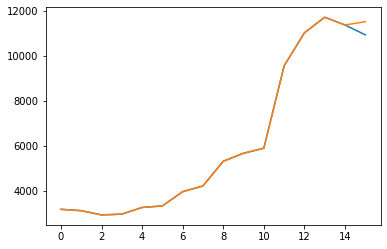

[ 3127  2939  2973  3270  3339  3973  4227  5324  5681  5905  9567 11036
 11729 11385 11531]
[[ 9567. 11036. 11729. 11385. 11531.]]
[[11931.569]]
[[12918.]]


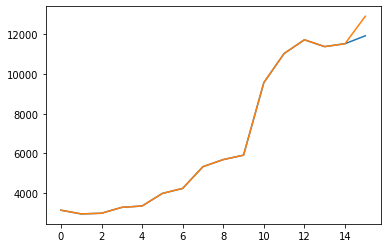

[ 2939  2973  3270  3339  3973  4227  5324  5681  5905  9567 11036 11729
 11385 11531 12918]
[[11036. 11729. 11385. 11531. 12918.]]
[[14255.856]]
[[13777.]]


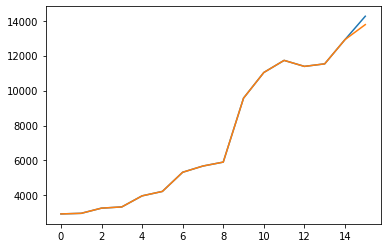

[ 2973  3270  3339  3973  4227  5324  5681  5905  9567 11036 11729 11385
 11531 12918 13777]
[[11729. 11385. 11531. 12918. 13777.]]
[[15275.513]]
[[16166.]]


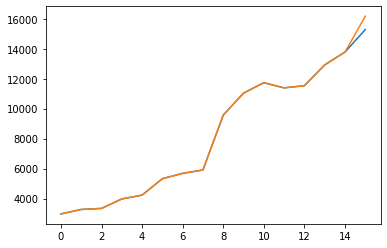

[ 3270  3339  3973  4227  5324  5681  5905  9567 11036 11729 11385 11531
 12918 13777 16166]
[[11385. 11531. 12918. 13777. 16166.]]
[[18238.264]]
[[18504.]]


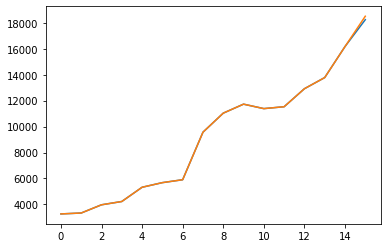

[ 3339  3973  4227  5324  5681  5905  9567 11036 11729 11385 11531 12918
 13777 16166 18504]
[[11531. 12918. 13777. 16166. 18504.]]
[[20394.51]]
[[23068.]]


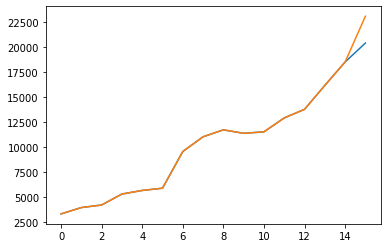

[ 3973  4227  5324  5681  5905  9567 11036 11729 11385 11531 12918 13777
 16166 18504 23068]
[[12918. 13777. 16166. 18504. 23068.]]
[[26059.709]]
[[29223.]]


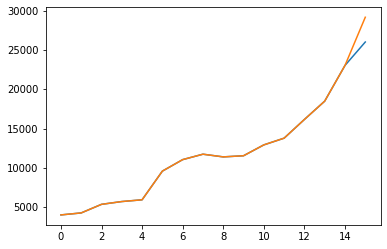

[ 4227  5324  5681  5905  9567 11036 11729 11385 11531 12918 13777 16166
 18504 23068 29223]
[[13777. 16166. 18504. 23068. 29223.]]
[[32764.37]]
[[37114.]]


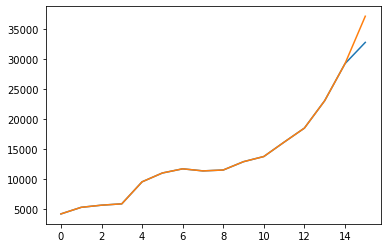

[ 5324  5681  5905  9567 11036 11729 11385 11531 12918 13777 16166 18504
 23068 29223 37114]
[[16166. 18504. 23068. 29223. 37114.]]
[[41264.754]]
[[42518.]]


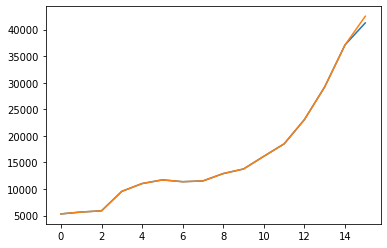

[ 5681  5905  9567 11036 11729 11385 11531 12918 13777 16166 18504 23068
 29223 37114 42518]
[[18504. 23068. 29223. 37114. 42518.]]
[[45186.082]]
[[38508.]]


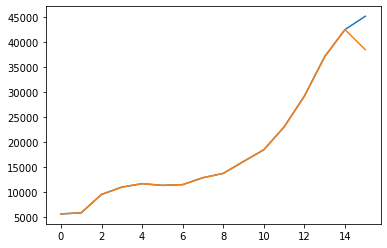

[ 5905  9567 11036 11729 11385 11531 12918 13777 16166 18504 23068 29223
 37114 42518 38508]
[[23068. 29223. 37114. 42518. 38508.]]
[[36589.54]]
[[35598.]]


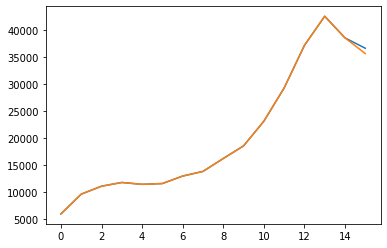

[ 9567 11036 11729 11385 11531 12918 13777 16166 18504 23068 29223 37114
 42518 38508 35598]
[[29223. 37114. 42518. 38508. 35598.]]
[[33945.973]]
[[34194.]]


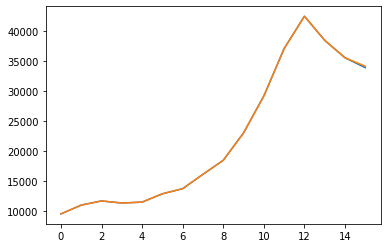

[11036 11729 11385 11531 12918 13777 16166 18504 23068 29223 37114 42518
 38508 35598 34194]
[[37114. 42518. 38508. 35598. 34194.]]
[[33701.383]]
[[32003.]]


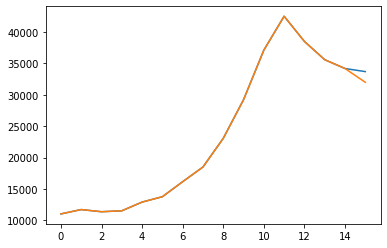

[11729 11385 11531 12918 13777 16166 18504 23068 29223 37114 42518 38508
 35598 34194 32003]
[[42518. 38508. 35598. 34194. 32003.]]
[[32205.33]]
[[29581.]]


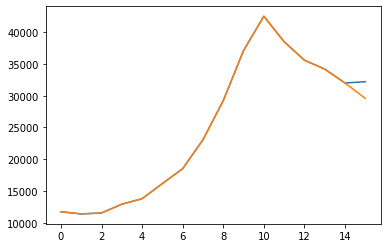

[11385 11531 12918 13777 16166 18504 23068 29223 37114 42518 38508 35598
 34194 32003 29581]
[[38508. 35598. 34194. 32003. 29581.]]
[[29262.492]]
[[26994.]]


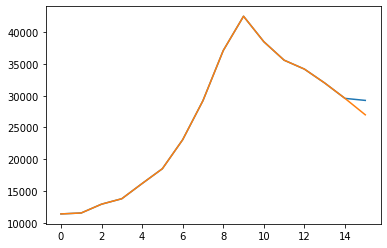

[11531 12918 13777 16166 18504 23068 29223 37114 42518 38508 35598 34194
 32003 29581 26994]
[[35598. 34194. 32003. 29581. 26994.]]
[[26262.201]]
[[24293.]]


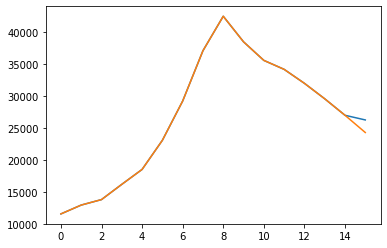

[12918 13777 16166 18504 23068 29223 37114 42518 38508 35598 34194 32003
 29581 26994 24293]
[[34194. 32003. 29581. 26994. 24293.]]
[[23397.902]]
[[22294.]]


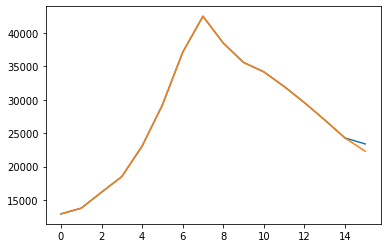

[13777 16166 18504 23068 29223 37114 42518 38508 35598 34194 32003 29581
 26994 24293 22294]
[[32003. 29581. 26994. 24293. 22294.]]
[[21687.59]]
[[20420.]]


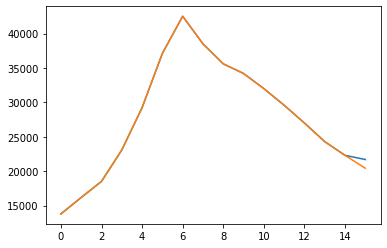

[16166 18504 23068 29223 37114 42518 38508 35598 34194 32003 29581 26994
 24293 22294 20420]
[[29581. 26994. 24293. 22294. 20420.]]
[[19991.316]]
[[19845.]]


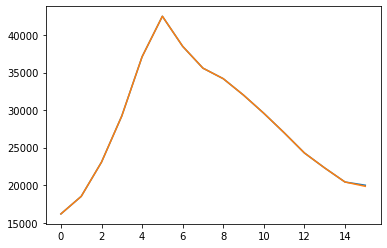

[18504 23068 29223 37114 42518 38508 35598 34194 32003 29581 26994 24293
 22294 20420 19845]
[[26994. 24293. 22294. 20420. 19845.]]
[[20165.4]]
[[18419.]]


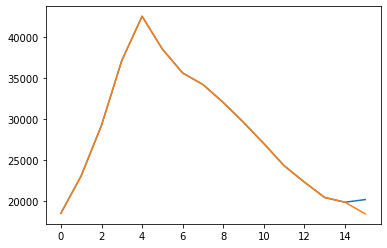

In [298]:
with torch.no_grad():
    model.eval()
    yearLow = 2013
    yearHigh = 2020
    df = pd.read_csv("data\FluViewPhase2Data\WHO_NREVSS_Combined_prior_to_2015_16.csv")
    df = df[(yearLow <= df["YEAR"]) & (df["YEAR"] < yearHigh)]["TOTAL"]
    data = np.array(df)
    for i in range(90,110):
        feat = test_data[i:i+1][0].numpy()
        pred = model(test_data[i:i+1][0]).numpy()
        act = test_data[i:i+1][1].numpy()
        full_back = data[i-10:i+5]
        print(full_back)
        print(feat)
        print(pred)
        print(act)
        # plt.plot(full_back)
        plt.plot(np.append(full_back,pred))
        plt.plot(np.append(full_back,act))
        plt.show()


Multi week prediction loop

In [299]:
def predictAhead(model, weeksAhead, feature):
    with torch.no_grad():
        container = torch.tensor([[0,0,0,0,0]],dtype=torch.float32)
        container[0] = feature[0]
        predList = torch.empty((1,weeksAhead),dtype=torch.float32,requires_grad=False)

        for i in range(weeksAhead):
            predList[:,i] = model(container)[0]
            temp = torch.cat((container[0], predList[:,i:i+1][0]))
            container[0] = temp[1:]
        
    return predList.numpy()

[ 3188  3127  2939  2973  3270  3339  3973  4227  5324  5681  5905  9567
 11036 11729 11385]
tensor([[ 5905.,  9567., 11036., 11729., 11385.]])
[10946.675 10994.638 11347.129]


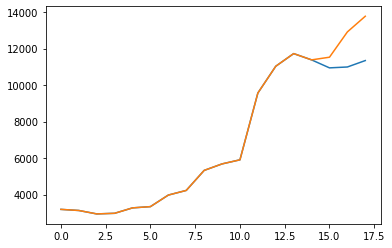

[ 3127  2939  2973  3270  3339  3973  4227  5324  5681  5905  9567 11036
 11729 11385 11531]
tensor([[ 9567., 11036., 11729., 11385., 11531.]])
[11931.569 12674.171 13805.017]


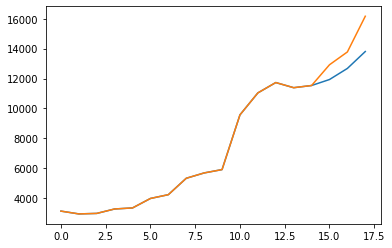

[ 2939  2973  3270  3339  3973  4227  5324  5681  5905  9567 11036 11729
 11385 11531 12918]
tensor([[11036., 11729., 11385., 11531., 12918.]])
[14255.856 16040.266 17801.451]


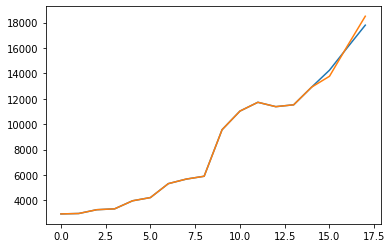

[ 2973  3270  3339  3973  4227  5324  5681  5905  9567 11036 11729 11385
 11531 12918 13777]
tensor([[11729., 11385., 11531., 12918., 13777.]])
[15275.513 16876.064 18431.826]


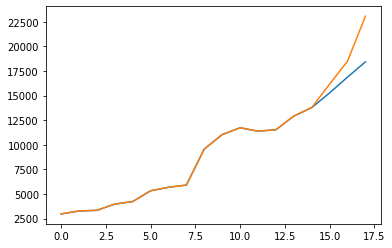

[ 3270  3339  3973  4227  5324  5681  5905  9567 11036 11729 11385 11531
 12918 13777 16166]
tensor([[11385., 11531., 12918., 13777., 16166.]])
[18238.264 19998.422 21622.836]


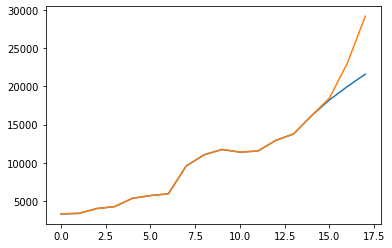

[ 3339  3973  4227  5324  5681  5905  9567 11036 11729 11385 11531 12918
 13777 16166 18504]
tensor([[11531., 12918., 13777., 16166., 18504.]])
[20394.51  22074.81  23512.775]


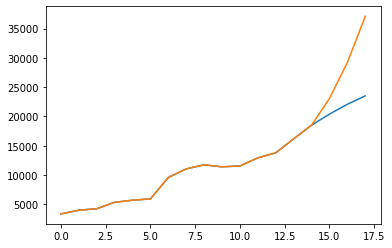

[ 3973  4227  5324  5681  5905  9567 11036 11729 11385 11531 12918 13777
 16166 18504 23068]
tensor([[12918., 13777., 16166., 18504., 23068.]])
[26059.709 28059.93  29554.537]


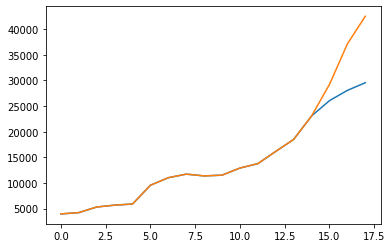

[ 4227  5324  5681  5905  9567 11036 11729 11385 11531 12918 13777 16166
 18504 23068 29223]
tensor([[13777., 16166., 18504., 23068., 29223.]])
[32764.37  34919.074 36123.906]


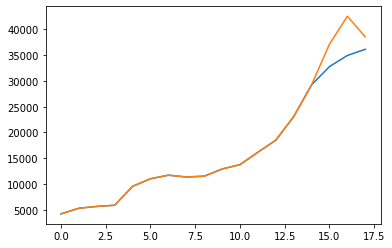

[ 5324  5681  5905  9567 11036 11729 11385 11531 12918 13777 16166 18504
 23068 29223 37114]
tensor([[16166., 18504., 23068., 29223., 37114.]])
[41264.754 43320.258 44415.04 ]


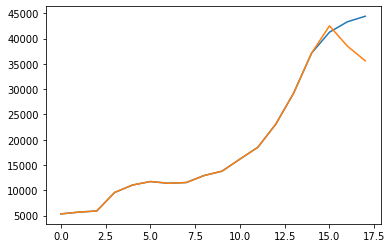

[ 5681  5905  9567 11036 11729 11385 11531 12918 13777 16166 18504 23068
 29223 37114 42518]
tensor([[18504., 23068., 29223., 37114., 42518.]])
[45186.082 46543.37  47883.14 ]


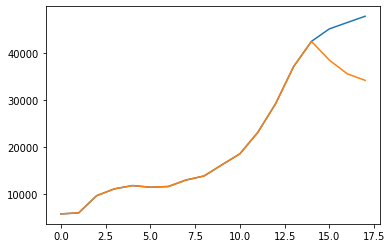

[ 5905  9567 11036 11729 11385 11531 12918 13777 16166 18504 23068 29223
 37114 42518 38508]
tensor([[23068., 29223., 37114., 42518., 38508.]])
[36589.54  35535.848 35555.53 ]


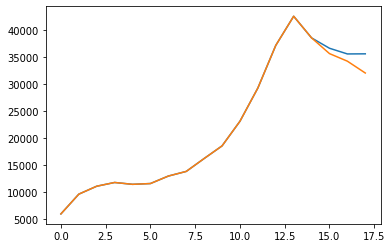

[ 9567 11036 11729 11385 11531 12918 13777 16166 18504 23068 29223 37114
 42518 38508 35598]
tensor([[29223., 37114., 42518., 38508., 35598.]])
[33945.973 33303.68  34365.29 ]


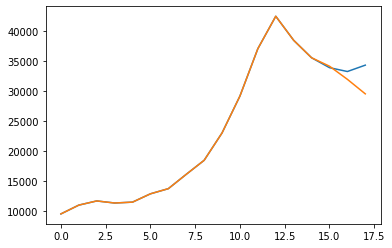

[11036 11729 11385 11531 12918 13777 16166 18504 23068 29223 37114 42518
 38508 35598 34194]
tensor([[37114., 42518., 38508., 35598., 34194.]])
[33701.383 34928.59  37327.6  ]


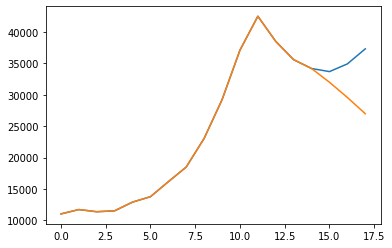

[11729 11385 11531 12918 13777 16166 18504 23068 29223 37114 42518 38508
 35598 34194 32003]
tensor([[42518., 38508., 35598., 34194., 32003.]])
[32205.33  33470.457 35859.637]


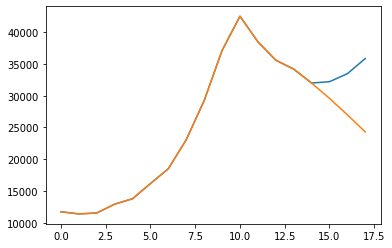

[11385 11531 12918 13777 16166 18504 23068 29223 37114 42518 38508 35598
 34194 32003 29581]
tensor([[38508., 35598., 34194., 32003., 29581.]])
[29262.492 29899.6   31707.307]


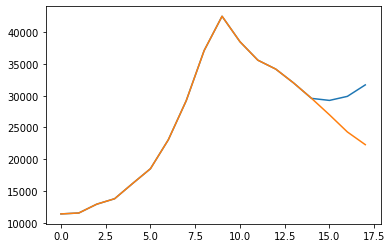

[11531 12918 13777 16166 18504 23068 29223 37114 42518 38508 35598 34194
 32003 29581 26994]
tensor([[35598., 34194., 32003., 29581., 26994.]])
[26262.201 26555.402 27929.824]


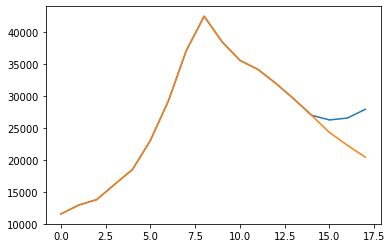

[12918 13777 16166 18504 23068 29223 37114 42518 38508 35598 34194 32003
 29581 26994 24293]
tensor([[34194., 32003., 29581., 26994., 24293.]])
[23397.902 23457.633 24530.861]


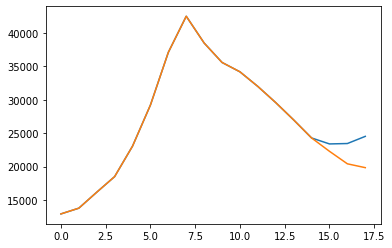

[13777 16166 18504 23068 29223 37114 42518 38508 35598 34194 32003 29581
 26994 24293 22294]
tensor([[32003., 29581., 26994., 24293., 22294.]])
[21687.59  22023.824 23278.793]


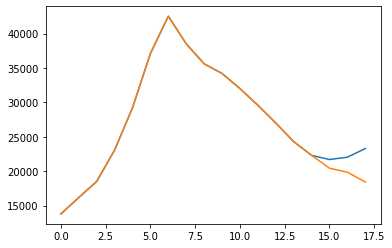

[16166 18504 23068 29223 37114 42518 38508 35598 34194 32003 29581 26994
 24293 22294 20420]
tensor([[29581., 26994., 24293., 22294., 20420.]])
[19991.316 20400.006 21606.186]


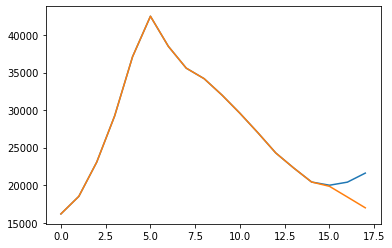

[18504 23068 29223 37114 42518 38508 35598 34194 32003 29581 26994 24293
 22294 20420 19845]
tensor([[26994., 24293., 22294., 20420., 19845.]])
[20165.4   21273.9   23108.729]


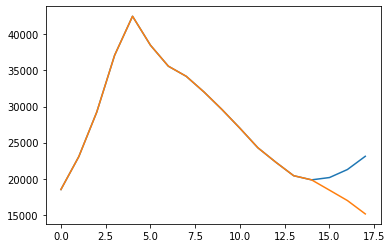

In [300]:
model.eval()
yearLow = 2013
yearHigh = 2100
df = pd.read_csv("data\FluViewPhase2Data\WHO_NREVSS_Combined_prior_to_2015_16.csv")
df = df[(yearLow <= df["YEAR"]) & (df["YEAR"] < yearHigh)]["TOTAL"]
data = np.array(df)
numAhead=3
for i in range(90,110):
    test = test_data[i:i+1]
    feat = test[0]
    pred = predictAhead(model,3,test_data[i:i+1][0])[0]
    act = test[1]
    full_back = data[i-10:i+5]
    real = data[i-10:i+5+numAhead]
    print(full_back)
    print(feat)
    print(pred)

    plt.plot(np.append(full_back,pred))
    plt.plot(real)
    plt.show()